## Data cleaning for cat data continued
### Goals
- Find peaks/useful sound slice regions for cat data (by detecting relatively sielnt regions)
- Test and finalize snippets fo be used in signal_slice.py
- Estimate the useful signal duration in second (by tag and total)

### Results
- Determined cut-off threshold: 4% of signal density defined by signal amplitude squared divided by total duration (units in frames) of the sound file.
- Finalized snippets to be used in signal_slice.py (determining signal slicing indicies then appending to a dataframe)
- Using 4% signal density threshold, minimum useful sound duration was determined:
     - about 318 s for pure meow sound
     - about 200 s for pure purr sound
     - about 333 s for meow and purr mix sound
     - about 46 s for sounds other than meow or purr
     - at least 896 s for total usable cat sound 
     
[Note] This uses cat data example, but the same approach can be used for dog data as well.   
I tested dog data to see if it needs different threshold. It seems the same 4% threshold also works well for slicing dog data.

In [179]:
from __future__ import division
import cPickle as pickle
import pandas as pd
import numpy as np
import librosa
from itertools import compress
import matplotlib.pyplot as plt
%matplotlib inline
import thinkdsp
import thinkplot
from itertools import compress
import os
from collections import Counter

In [2]:
with open('cat_inspect_df.pkl') as f:
    df = pickle.load(f)

In [85]:
def signalplot(filename,start=0,end=None): #start and end time in second
    y, sr = librosa.load(filename)
    t = np.arange(len(y))/sr
    i = int(round(start * sr))
    if end != None:
        j = int(round(end * sr))
    else:
        j = len(y)    
    plt.plot(t[i:j],y[i:j]);

def findpeak(y,sr): 
    hop = int(round(sr*1)) #hop and width defines search window
    width = sr*1 
    n_slice = int(len(y)/hop)
    starts = np.arange(n_slice)*hop
    ends = starts+width

    if hop != width:
        cutoff = np.argmax(ends>len(y))
        starts = starts[:cutoff]
        ends = ends[:cutoff]
        n_slice = len(starts)
    mask = map(lambda i: np.dot(y[starts[i]:ends[i]],y[starts[i]:ends[i]])/width, range(n_slice)) > np.dot(y,y)/len(y)
    starts =  list(compress(starts,mask))
    ends = list(compress(ends,mask))
    peaks = map(lambda i: starts[i]+np.argmax(y[starts[i]:ends[i]]), range(len(starts)))
    starts = np.array(peaks)-int(width/2)
    ends = starts+width
    return zip(starts,ends)


In [5]:
df = df[df['discard']==False]

In [10]:
clean_meow = df[(df['meow']==True)&(df['purr']==False)&(df['background']==False)&(df['other']==False)]
print len(clean_meow)
print clean_meow['duration'].median()

25
3.0


In [17]:
clean_purr = df[(df['meow']==False)&(df['purr']==True)&(df['background']==False)&(df['other']==False)]
print len(clean_purr)
print clean_purr['duration'].median()

4
23.066122449


In [450]:
def findsilence(y,sr,ind_i): 
    hop = int(round(sr*0.2)) #hop and width defines search window
    width = sr*0.2 
    n_slice = int(len(y)/hop)
    starts = np.arange(n_slice)*hop
    ends = starts+width
    if hop != width:
        cutoff = np.argmax(ends>len(y))
        starts = starts[:cutoff]
        ends = ends[:cutoff]
        n_slice = len(starts)
    mask = map(lambda i: np.dot(y[starts[i]:ends[i]],y[starts[i]:ends[i]])/width, range(n_slice)) < 0.04 * np.dot(y,y)/len(y)
    starts =  list(compress(starts+ind_i,mask))
    ends = list(compress(ends+ind_i,mask))
    #silence = map(lambda i: starts[i]+np.argmax(y[starts[i]:ends[i]]), range(len(starts)))
    #starts = np.array(peaks)-int(width/2)
    #ends = starts+width
    return zip(starts,ends)

def shade_silence(filename,start=0,end=None,disp=True,output=False, itr=''): #start and end time in second
    try:
        y, sr = librosa.load(filename)
    except:
        obj = thinkdsp.read_wave(filename)
        y = obj.ys
        sr = obj.framerate
        print itr, ' : librosa.load failed for '+filename
 
    t = np.arange(len(y))/sr

    i = int(round(start * sr))
    if end != None:
        j = int(round(end * sr))
    else:
        j = len(y)  
    fills = findsilence(y[i:j],sr,i) 
    if disp:
        fig, ax = plt.subplots()   
        ax.set_title(filename)
        ax.plot(t[i:j],y[i:j])
    if fills != None:
        shades = map(lambda x: (max(x[0],i),min(x[1],j)), fills)
        if len(shades)>0:
            shades = merger(shades)    
            if disp:
                for s in shades:
                    ax.axvspan(s[0]/sr, s[1]/sr, alpha=0.5, color='red')      
    if len(shades)>1:
        live = map(lambda i: (shades[i][1],shades[i+1][0]),xrange(len(shades)-1))
    elif len(shades)==1:
        a = [i,shades[0][0],shades[0][1],j]
        live = filter(lambda x: x != None, map(lambda x: tuple(x) if x[0]!=x[1] else None,np.sort(a).reshape((int(len(a)/2),2))))
    else:
        live = [(i,j)]
    if output:
        return live, sr, len(y)
    
def merger(tulist):
    tu=()
    for tt in tulist:
         tu += tt
    cnt = Counter(tu)
    res = filter(lambda x: cnt[x]<2, tu)
    return map(lambda x: tuple(x),np.array(res).reshape((len(res)/2,2)))  

def post2df(df):
    active=[]
    srs=[]
    dur=[]
    i=0
    for fn in df['filename']:
        tlist, sr , leng = shade_silence(directory+'/'+fn, disp=False, output=True, itr=i)
        active.append(tlist)
        srs.append(sr)
        dur.append(leng/sr)
        i+=1   
    return active, srs, dur        

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


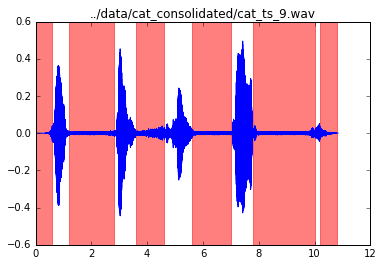

In [339]:
shade_silence(directory+'/'+clean_meow['filename'].iloc[5])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


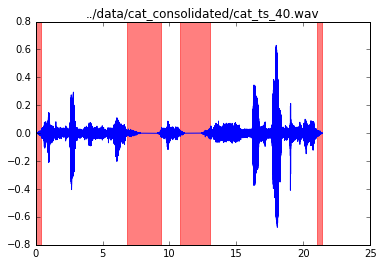

In [321]:
shade_silence(directory+'/'+clean_meow['filename'].iloc[2])

### Outputs from for loops below were cleared to reduce the notebook size. Run again if needed.

In [ ]:
for fn in clean_meow['filename']:
    shade_silence(directory+'/'+fn)

In [ ]:
for fn in clean_purr['filename']:
    shade_silence(directory+'/'+fn)

In [ ]:
for fn in meow_purr_mix['filename']:
    shade_silence(directory+'/'+fn)

## [Do Not Run Cells Below]
### The codes below are to append slicing indices and other info
#### [Caution] function post2df has been changed since, so it will not run properly for some of codes below.

In [387]:
df['active_region'], df['sr'] = post2df(df)

45  : librosa.load failed for ../data/cat_consolidated/meow_fs_26.wav
47  : librosa.load failed for ../data/cat_consolidated/meow_fs_29.wav
56  : librosa.load failed for ../data/cat_consolidated/meow_fs_4.wav
74  : librosa.load failed for ../data/cat_consolidated/meow_fs_8.wav


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [388]:
df.head()

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr
0,cat_ts_1.wav,True,False,False,False,True,False,17.475918,"[(17640.0, 30870.0), (39690.0, 52920.0), (5733...",22050
1,cat_ts_10.wav,False,True,False,False,True,False,28.995918,"[(8820.0, 639360.0)]",22050
2,cat_ts_11.wav,True,True,False,False,False,False,25.077551,"[(13230.0, 26460.0), (61740.0, 79380.0), (9702...",22050
3,cat_ts_12.wav,False,True,False,False,False,False,23.797551,"[(4410.0, 524736.0)]",22050
4,cat_ts_13.wav,False,True,False,False,False,False,22.334694,"[(0.0, 485100.0), (489510.0, 492480.0)]",22050


In [389]:
df.iloc[[45,47,56,74]]

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr
62,meow_fs_26.wav,True,False,False,False,True,False,16.436438,"[(67200.0, 115200.0), (268800.0, 307200.0), (4...",48000
64,meow_fs_29.wav,True,False,False,False,True,False,1.811313,"[(9600.0, 76800.0)]",48000
73,meow_fs_4.wav,True,False,False,False,True,False,1.637292,"[(28800.0, 67200.0)]",48000
96,meow_fs_8.wav,True,False,False,False,False,False,1.201208,"[(0, 57658)]",48000


In [418]:
df['sig_len'] = df['active_region'].apply(lambda y: np.array(map(lambda x: x[1]-x[0],y)))/df['sr']
df['num_sig'] = df['sig_len'].apply(lambda x: len(x))
df['sig_len_sum'] = df['sig_len'].apply(lambda x: sum(x))

In [419]:
df.head()

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr,sig_len,num_sig,sig_len_sum
0,cat_ts_1.wav,True,False,False,False,True,False,17.475918,"[(17640.0, 30870.0), (39690.0, 52920.0), (5733...",22050,"[0.6, 0.6, 0.8, 0.6, 0.6, 0.6, 1.0, 0.6, 0.8, ...",14,9.600000
1,cat_ts_10.wav,False,True,False,False,True,False,28.995918,"[(8820.0, 639360.0)]",22050,[28.5959183673],1,28.595918
2,cat_ts_11.wav,True,True,False,False,False,False,25.077551,"[(13230.0, 26460.0), (61740.0, 79380.0), (9702...",22050,"[0.6, 0.8, 1.2, 1.0, 6.2, 1.0, 0.2, 0.8, 0.8, ...",12,16.400000
3,cat_ts_12.wav,False,True,False,False,False,False,23.797551,"[(4410.0, 524736.0)]",22050,[23.5975510204],1,23.597551
4,cat_ts_13.wav,False,True,False,False,False,False,22.334694,"[(0.0, 485100.0), (489510.0, 492480.0)]",22050,"[22.0, 0.134693877551]",2,22.134694


In [423]:
meow_no_purr = df[(df['meow']==True)&(df['purr']==False)&(df['sig_len_sum']>0.5)]

In [424]:
meow_no_purr['sig_len_sum'].sum()

306.33118565759634

In [425]:
meow_no_purr['num_sig'].sum()

237

In [426]:
clean_meow =  df[(df['meow']==True)&(df['purr']==False)&(df['background']==False)&(df['other']==False)&(df['sig_len_sum']>0.5)]

In [427]:
print len(clean_meow)
print clean_meow['sig_len_sum'].sum()
print clean_meow['num_sig'].sum()

23
111.730278628
88


In [428]:
with open('cat_slice_df.pkl','w') as f:
    pickle.dump(df,f)

In [432]:
more=[68,69,70,71]
names = map(lambda m:'meow_fs_'+str(m)+'.wav', more)

In [441]:
df2 = pd.DataFrame(columns = df.columns.values)

In [443]:
df2['filename']=names

In [444]:
df2

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr,sig_len,num_sig,sig_len_sum
0,meow_fs_68.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,meow_fs_69.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,meow_fs_70.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,meow_fs_71.wav,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [447]:
df2['meow'] = map(lambda _: True, range(4))
df2[['hiss','other','background','discard']] = map(lambda _: False, range(4))

In [449]:
df2['purr']=[False,True,True,True]

In [451]:
df2['active_region'], df2['sr'], df2['duration'] = post2df(df2)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [452]:
df2

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr,sig_len,num_sig,sig_len_sum
0,meow_fs_68.wav,True,False,False,False,False,False,18.898549,"[(30870.0, 52920.0), (74970.0, 88200.0), (1014...",22050,NaN,NaN,NaN
1,meow_fs_69.wav,True,True,False,False,False,False,232.675193,"[(8820.0, 30870.0), (105840.0, 114660.0), (167...",22050,NaN,NaN,NaN
2,meow_fs_70.wav,True,True,False,False,False,False,31.114739,"[(13230.0, 26460.0), (30870.0, 52920.0), (7056...",22050,NaN,NaN,NaN
3,meow_fs_71.wav,True,True,False,False,False,False,232.675193,"[(8820.0, 30870.0), (105840.0, 114660.0), (167...",22050,NaN,NaN,NaN


In [453]:
df['meow'].unique()

array([True, False], dtype=object)

In [455]:
df2['sig_len'] = df2['active_region'].apply(lambda y: np.array(map(lambda x: x[1]-x[0],y)))/df['sr']
df2['num_sig'] = df2['sig_len'].apply(lambda x: len(x))
df2['sig_len_sum'] = df2['sig_len'].apply(lambda x: sum(x))

In [456]:
df2

,filename,meow,purr,hiss,other,background,discard,duration,active_region,sr,sig_len,num_sig,sig_len_sum
0,meow_fs_68.wav,True,False,False,False,False,False,18.898549,"[(30870.0, 52920.0), (74970.0, 88200.0), (1014...",22050,"[1.0, 0.6, 0.8, 0.8, 0.8, 0.2, 1.0, 0.2, 0.6, ...",14,10.8
1,meow_fs_69.wav,True,True,False,False,False,False,232.675193,"[(8820.0, 30870.0), (105840.0, 114660.0), (167...",22050,"[1.0, 0.4, 0.4, 0.6, 0.4, 1.0, 1.0, 0.4, 1.4, ...",105,80.4
2,meow_fs_70.wav,True,True,False,False,False,False,31.114739,"[(13230.0, 26460.0), (30870.0, 52920.0), (7056...",22050,"[0.6, 1.0, 0.4, 4.4, 2.0, 10.2, 2.2, 0.6, 2.2,...",10,25.4
3,meow_fs_71.wav,True,True,False,False,False,False,232.675193,"[(8820.0, 30870.0), (105840.0, 114660.0), (167...",22050,"[1.0, 0.4, 0.4, 0.6, 0.4, 1.0, 1.0, 0.4, 1.4, ...",105,80.4


In [459]:
dfc = df.copy()

In [462]:
dfc.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 20,
       21, 22, 25, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 51, 52, 55, 57, 58, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88,
       89, 90, 92, 93, 94, 95, 96, 97])

In [463]:
df.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 20,
       21, 22, 25, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 51, 52, 55, 57, 58, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88,
       89, 90, 92, 93, 94, 95, 96, 97])

In [464]:
newdf = df.append(df2,ignore_index=True)

In [465]:
newdf.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [476]:
with open('cat_slice_df_final.pkl','w') as f:
    pickle.dump(newdf,f)

In [474]:
newdf[(newdf['purr']==False)&(newdf['meow']==False)]['sig_len_sum'].sum()

46.160453514739224

In [475]:
newdf['sig_len_sum'].sum()

896.63463236961456